In [18]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from queue import PriorityQueue


In [19]:
print("hello world")

hello world


In [20]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with weights (inferred from image)
edges = [
    ("Attacker", "Pad", {"user": 0.6, "root": 0.6}),
    ("Attacker", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Attacker", "Host 1", {"user": 0.6, "root": 0.48}),

    ("Pad", "Host 1", {"user": 0.6, "root": 0.48}),
    ("Pad", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Pad", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Pad", "Web Server", {"user": 0.8, "root": 0.6}),

    ("Host 1", "Pad", {"user": 0.6, "root": 0.6}),
    ("Host 1", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Host 1", "Host 3", {"user": 0.32, "root": 0.32}),

    ("Host 2", "Host 3", {"user": 0.8, "root": 0.8}),
    ("Host 2", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 2", "Data Server", {"user": 0.8, "root": 0.6}),

    ("Host 3", "Host 2", {"user": 0.8, "root": 0.8}),
    ("Host 3", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 3", "Data Server", {"user": 0.8, "root": 0.6}),

    ("Web Server", "File Server", {"user": 0.8, "root": 0.04}),
    ("Web Server", "Data Server", {"user": 0.8, "root": 0.04}),

    ("File Server", "Data Server", {"user": 0.8, "root": 0.04})
]

# Add edges to the graph
G.add_edges_from(edges)

# Print nodes and edges
print("Nodes:", G.nodes())
print("Edges:")
for u, v, attr in G.edges(data=True):
    print(f"{u} -> {v}, weights: user={attr['user']}, root={attr['root']}")


Nodes: ['Attacker', 'Pad', 'Web Server', 'Host 1', 'Host 2', 'Host 3', 'File Server', 'Data Server']
Edges:
Attacker -> Pad, weights: user=0.6, root=0.6
Attacker -> Web Server, weights: user=0.8, root=0.6
Attacker -> Host 1, weights: user=0.6, root=0.48
Pad -> Host 1, weights: user=0.6, root=0.48
Pad -> Host 2, weights: user=0.32, root=0.32
Pad -> Host 3, weights: user=0.32, root=0.32
Pad -> Web Server, weights: user=0.8, root=0.6
Web Server -> File Server, weights: user=0.8, root=0.04
Web Server -> Data Server, weights: user=0.8, root=0.04
Host 1 -> Pad, weights: user=0.6, root=0.6
Host 1 -> Web Server, weights: user=0.8, root=0.6
Host 1 -> Host 2, weights: user=0.32, root=0.32
Host 1 -> Host 3, weights: user=0.32, root=0.32
Host 2 -> Host 3, weights: user=0.8, root=0.8
Host 2 -> File Server, weights: user=0.8, root=0.6
Host 2 -> Data Server, weights: user=0.8, root=0.6
Host 3 -> Host 2, weights: user=0.8, root=0.8
Host 3 -> File Server, weights: user=0.8, root=0.6
Host 3 -> Data Serv

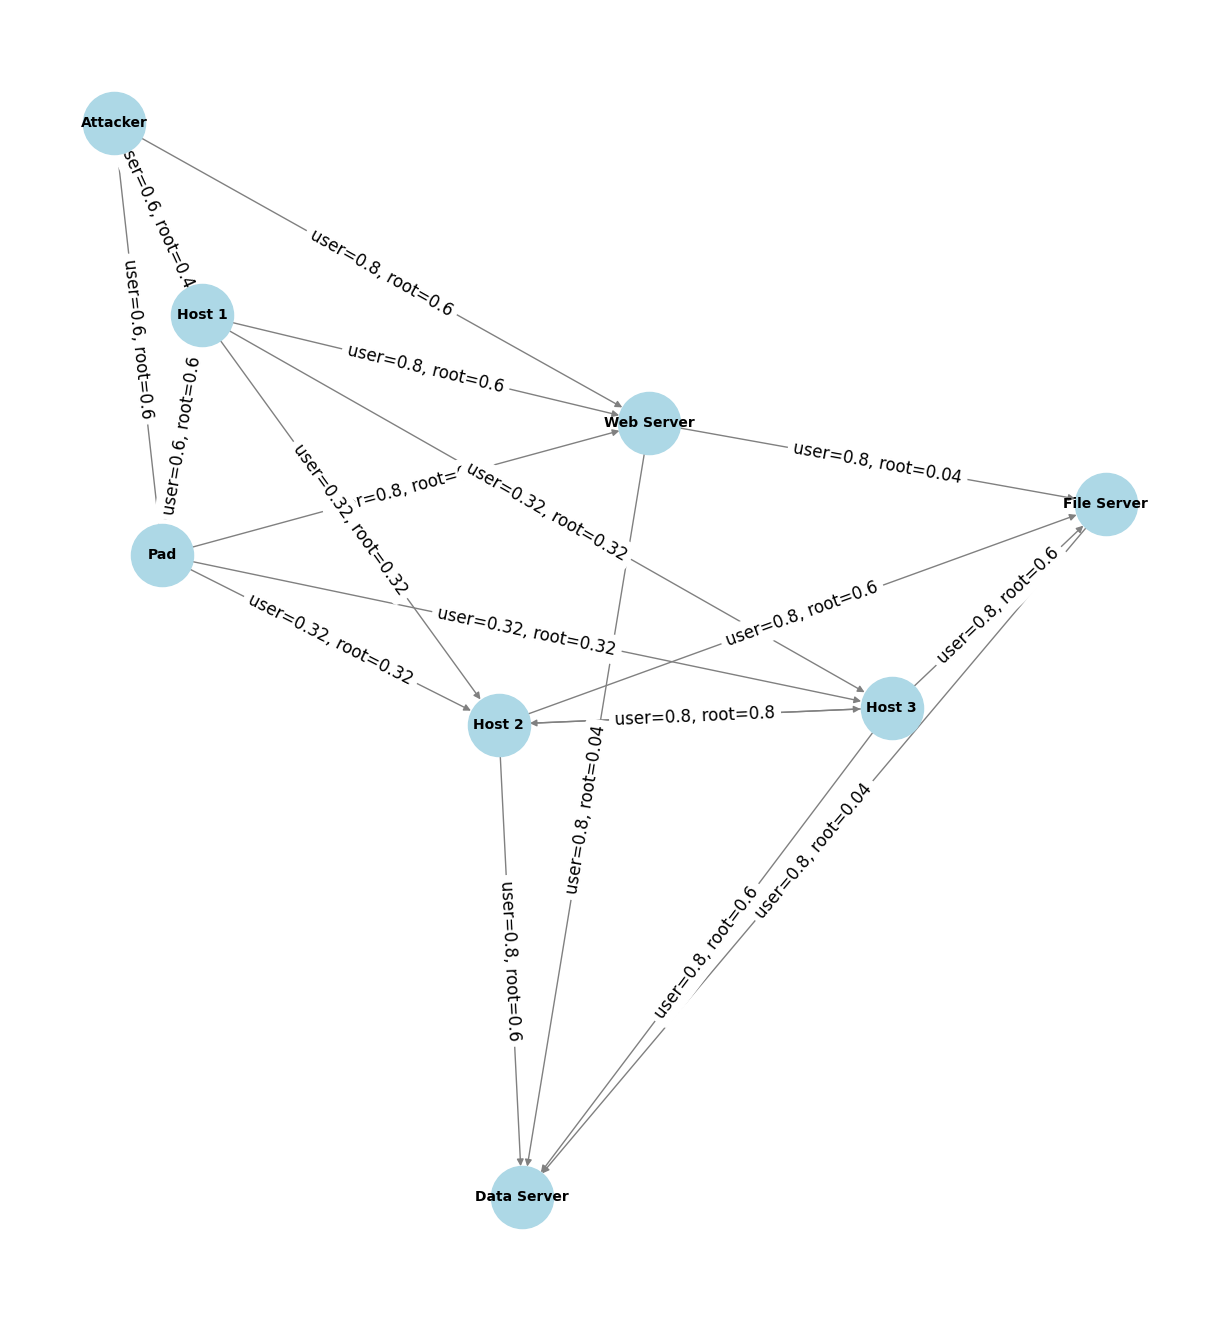

In [21]:

# Draw the graph
plt.figure(figsize=(12, 13))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=10, font_weight='bold')

# Draw edge labels with weights
edge_labels = {(u, v): f"user={d['user']}, root={d['root']}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

plt.show()

In [22]:
# Q-learning parameters
alpha = 0.005  # Reduced learning rate
gamma = 0.9  # Discount factor
epsilon_start = 0.3
epsilon_end = 0.01
epsilon_decay = 0.999
num_episodes = 10000
max_honeypots = 2


In [23]:
# Node indexing (excluding Attacker for state array)
nodes = [node for node in G.nodes() if node != "Attacker"]
num_nodes = len(nodes)
node_to_idx = {node: idx for idx, node in enumerate(nodes)}
idx_to_node = {idx: node for node, idx in node_to_idx.items()}
graph_node_to_idx = {node: idx for idx, node in enumerate(G.nodes())}

In [24]:
# Initialize Q-table
Q = np.zeros((2**num_nodes, num_nodes))

initial_state = [0] * num_nodes


In [25]:

# Hash state array to index
def state_to_index(state):
    return int("".join(map(str, state)), 2)


# Get possible honeypot placements
def get_possible_honeypot_actions(honeypots):
    return [node for node in nodes if node not in honeypots and node != "Data Server"]

# Reward function
def get_reward(path, goal, honeypots):
    if any(node in honeypots for node in path):
        return 1
    if goal in path:
        return -1
    return 0

# Choose action (place honeypot)
def choose_action(state, honeypots, Q, epsilon):
    possible_actions = get_possible_honeypot_actions(honeypots)
    if not possible_actions:
        return None
    
    state_idx = state_to_index(state)
    if random.uniform(0, 1) < epsilon:
        return random.choice(possible_actions)
    else:
        q_values = [Q[state_idx][node_to_idx[node]] for node in possible_actions]
        best_action_idx = np.argmax(q_values)
        return possible_actions[best_action_idx]




In [26]:
    
# Attacker's greedy attack with goal
def greedy_attack_priority_queue(graph, honeypots, goal):
    captured = {"Attacker"}
    path = ["Attacker"]
    pq = PriorityQueue()
    for neighbor in graph.successors("Attacker"):
        weight = max(graph["Attacker"][neighbor]['user'], graph["Attacker"][neighbor]['root'])
        pq.put((-weight, neighbor))
    
    while not pq.empty():
        neg_weight, to_node = pq.get()
        weight = -neg_weight
        if to_node in honeypots:
            path.append(to_node)
            captured.add(to_node)
            break
        if to_node not in captured:
            captured.add(to_node)
            path.append(to_node)
            if to_node == goal:
                break
            for next_node in graph.successors(to_node):
                if next_node not in captured:
                    next_weight = max(graph[to_node][next_node]['user'], graph[to_node][next_node]['root'])
                    pq.put((-next_weight, next_node))
    return path, captured

In [31]:
# Q-learning 
epsilon = epsilon_start
dsp = 0
for episode in range(num_episodes):
    honeypots = set()
    state = initial_state.copy()
    
    # Place all honeypots before attack
    actions = []
    for _ in range(max_honeypots):
        action = choose_action(state, honeypots, Q, epsilon)
        if action is None:
            break
        honeypots.add(action)
        actions.append((action, node_to_idx[action]))
    
    
    
    # Simulate attack
    attack_path, attack_captured  = greedy_attack_priority_queue(G, honeypots, "Data Server")
    
    
    
    
    # Update state (include honeypots as attacked)
    new_state = [0] * num_nodes
    for node in attack_path:
        if node != "Attacker":
            new_state[node_to_idx[node]] = 1
    
    
    
    
    
    # Calculate reward
    reward = get_reward(attack_path, "Data Server", honeypots)
    if (reward == 1) :
        dsp += 1
    # Update Q-values for each action
    state_idx = state_to_index(state)
    new_state_idx = state_to_index(new_state)
    best_next_q = min(max(np.max(Q[new_state_idx]) if get_possible_honeypot_actions(honeypots) else 0, -1), 1)  # Cap Q-values
    for action, action_idx in actions:
        Q[state_idx][action_idx] += alpha * (reward + gamma * best_next_q - Q[state_idx][action_idx])
    
    
    
    
    
    # Update state and epsilon
    state = new_state
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    
    
    
    # Debug: Log episode results
    if episode % 1000 == 0:
        initial_state_idx = state_to_index(initial_state)
        q_vals = {idx_to_node[i]: Q[initial_state_idx][i] for i in range(num_nodes)}
        if episode!=0 :
            dsp/=1000
        print(f"Episode {episode}: Honeypots={honeypots}, Path={' -> '.join(attack_path)}, State={new_state}, Reward={reward}, Defense success probability={dsp}")
        dsp=0





Episode 0: Honeypots={'Web Server', 'Host 1'}, Path=Attacker -> Web Server, State=[0, 1, 0, 0, 0, 0, 0], Reward=1, Defense success probability=1
Episode 1000: Honeypots={'Web Server', 'File Server'}, Path=Attacker -> Web Server, State=[0, 1, 0, 0, 0, 0, 0], Reward=1, Defense success probability=0.973
Episode 2000: Honeypots={'Web Server', 'File Server'}, Path=Attacker -> Web Server, State=[0, 1, 0, 0, 0, 0, 0], Reward=1, Defense success probability=0.996
Episode 3000: Honeypots={'Web Server', 'File Server'}, Path=Attacker -> Web Server, State=[0, 1, 0, 0, 0, 0, 0], Reward=1, Defense success probability=1.0
Episode 4000: Honeypots={'Web Server', 'File Server'}, Path=Attacker -> Web Server, State=[0, 1, 0, 0, 0, 0, 0], Reward=1, Defense success probability=0.999
Episode 5000: Honeypots={'Web Server', 'File Server'}, Path=Attacker -> Web Server, State=[0, 1, 0, 0, 0, 0, 0], Reward=1, Defense success probability=1.0
Episode 6000: Honeypots={'Web Server', 'File Server'}, Path=Attacker -> We

In [28]:
# Extract optimal honeypot placement
# For testing purpose
def get_optimal_honeypots(Q): 
    state = [0] * num_nodes
    honeypots = []
    
    for _ in range(max_honeypots):
        action = choose_action(state, set(honeypots), Q, epsilon=0)  # No exploration
        if action is None:
            break
        honeypots.append(action)
        honeypots_set = set(honeypots)
        attack_path, _ = greedy_attack_priority_queue(G, honeypots_set, "Data Server")
        new_state = [0] * num_nodes
        for node in attack_path:
            if node != "Attacker":
                new_state[node_to_idx[node]] = 1
        state = new_state
    
    return honeypots

# Test and print results
optimal_honeypots= get_optimal_honeypots(Q)
print("\nFinal Results:")
print("Optimal honeypot placements:", optimal_honeypots)
attack_path, attack_captured = greedy_attack_priority_queue(G, set(optimal_honeypots), "Data Server")
print("Attacker's path with honeypots:", " -> ".join(attack_path))
print("Nodes captured by attacker:", sorted(attack_captured))
print("State array after attack:", [1 if node in attack_captured and node != "Attacker" else 0 for node in nodes])
print("Reward:", get_reward(attack_path, "Data Server", set(optimal_honeypots)))


Final Results:
Optimal honeypot placements: ['Web Server', 'Pad']
Attacker's path with honeypots: Attacker -> Web Server
Nodes captured by attacker: ['Attacker', 'Web Server']
State array after attack: [0, 1, 0, 0, 0, 0, 0]
Reward: 1


In [29]:
# Print Q-values for initial state
initial_state_idx = state_to_index([0] * num_nodes)
print("\nQ-values for initial state:")
for idx in range(num_nodes):
    print(f"- {idx_to_node[idx]}: {Q[initial_state_idx][idx]:.4f}")


Q-values for initial state:
- Pad: 0.3965
- Web Server: 1.0000
- Host 1: 0.4237
- Host 2: 0.3564
- Host 3: 0.4033
- File Server: 1.0000
- Data Server: 0.0000
